In [13]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join('', os.pardir)))
analysis_dir = os.path.abspath(os.path.join('', os.pardir))
sys.path.insert(0, os.path.abspath(os.path.join(analysis_dir, os.pardir)))
from utils.misc import read_json_file
from src.ml.helper.utils import parse_traces_config

analysis_dir = os.path.abspath(os.path.join('', os.pardir))
root_dir = os.path.abspath(os.path.join(analysis_dir, os.pardir))
path_to_plot_dir = "/home/lorenzo/Desktop/mimic-2/analysis/plots/thruput_vs_rtt"

In [46]:
# Get config

# Select policy
policy = "bootstrapped_ucb"

log_dir_path = os.path.join(root_dir, 'log')
mab_dir_path = os.path.join(log_dir_path, 'mab', 'config')
config_file_name = policy + '.json'
file_path = os.path.join(mab_dir_path, config_file_name)
config = read_json_file(file_path)

# Get model timestamp
model_name = config["models"][0]['name']
model_ts = '.'.join(model_name.split('.')[1:])
model_ts

'2023.04.04.04.04.57'

In [37]:
# Read trace names and paths from YAML file
trace_data = parse_traces_config()
traces = [t for t in trace_data['traces'].keys()]
traces

['att.lte.driving',
 'att.lte.driving.2016',
 'tm.lte.driving',
 'tm.lte.short',
 'tm.umts.driving',
 'vz.evdo.driving',
 'vz.lte.driving',
 'vz.lte.short',
 'bus',
 'timessquare',
 'wired']

In [38]:
import re
from datetime import datetime

# Get iperf config
def get_config(tag):
    iperf_test_dir_path = os.path.join(log_dir_path, 'iperf')
    ts_list = []
    latest_timestamp = None
    mimic_config_file = None

    for config_file in os.listdir(iperf_test_dir_path):
        if config_file.startswith(tag):
            full_path = os.path.join(iperf_test_dir_path, config_file)
            # print(config_file)
            pattern = r"\d{4}\.\d{2}\.\d{2}\.\d{2}\.\d{2}\.\d{2}"
            match = re.search(pattern, config_file)
            if not match:
                continue
            timestamp_str = match.group(0)
            timestamp = datetime.strptime(timestamp_str, "%Y.%m.%d.%H.%M.%S")
            ts_list.append(timestamp)
            # check if this timestamp is more recent
            if latest_timestamp is None or timestamp > latest_timestamp:
                latest_timestamp = timestamp
                mimic_config_file = full_path
    return mimic_config_file

In [34]:
trace = 'att.lte.driving'
test = read_json_file(get_config('att.lte.driving.random_policy'))
print(test)

{'start': {'connected': [{'socket': 5, 'local_host': '100.64.0.2', 'local_port': 34548, 'remote_host': '10.0.2.15', 'remote_port': 5201}], 'version': 'iperf 3.1.3', 'system_info': 'Linux ubuntu-bionic 5.4.239 #2 SMP Tue Apr 4 21:06:07 CDT 2023 x86_64', 'timestamp': {'time': 'Thu, 06 Apr 2023 05:31:43 GMT', 'timesecs': 1680759103}, 'connecting_to': {'host': '10.0.2.15', 'port': 5201}, 'cookie': 'ubuntu-bionic.1680759102.969930.3e68', 'tcp_mss_default': 1448, 'test_start': {'protocol': 'TCP', 'num_streams': 1, 'blksize': 131072, 'omit': 0, 'duration': 60, 'bytes': 0, 'blocks': 0, 'reverse': 0}}, 'intervals': [{'streams': [{'socket': 5, 'start': 0, 'end': 1.000703, 'seconds': 1.000703, 'bytes': 318560, 'bits_per_second': 2546689.431855, 'retransmits': 0, 'snd_cwnd': 70952, 'rtt': 423525, 'omitted': False}], 'sum': {'start': 0, 'end': 1.000703, 'seconds': 1.000703, 'bytes': 318560, 'bits_per_second': 2546689.431855, 'retransmits': 0, 'omitted': False}}, {'streams': [{'socket': 5, 'start': 

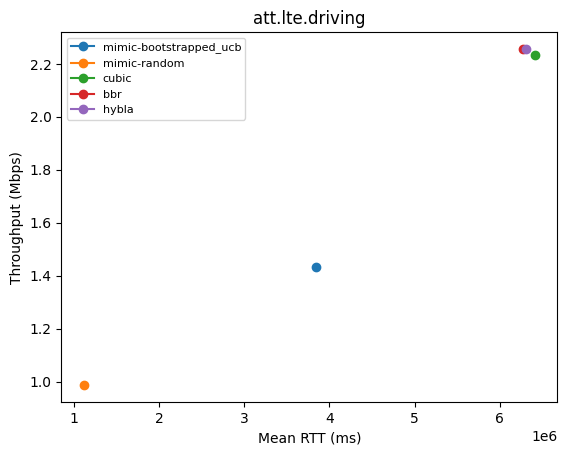

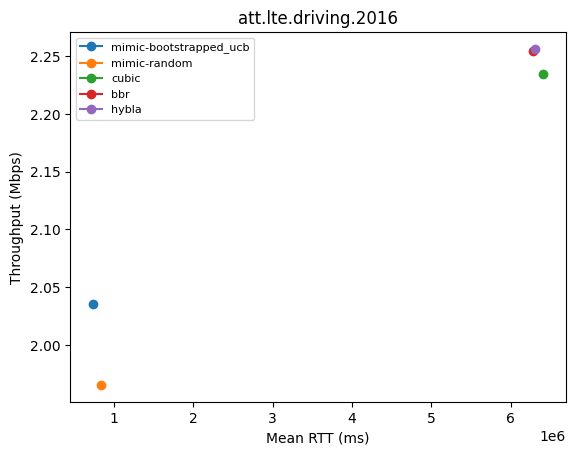

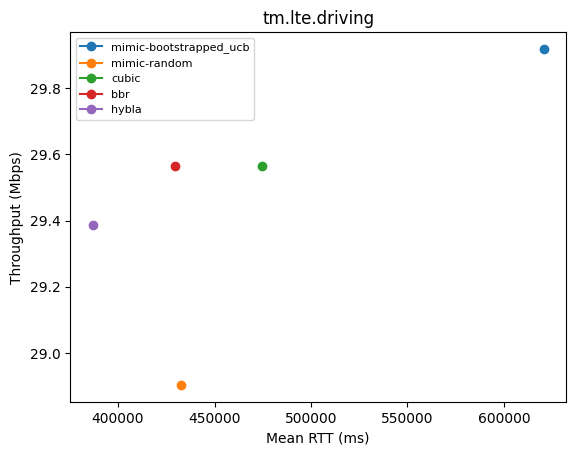

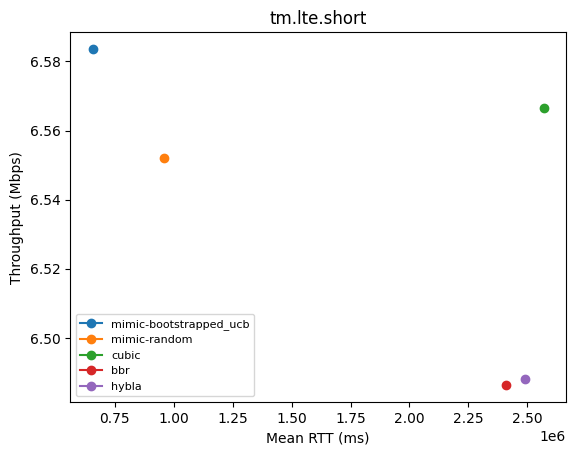

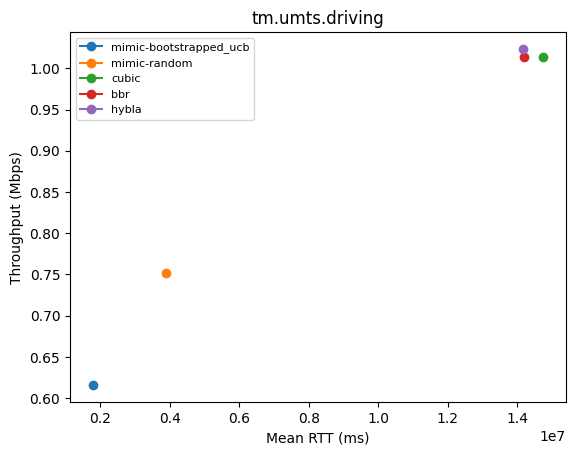

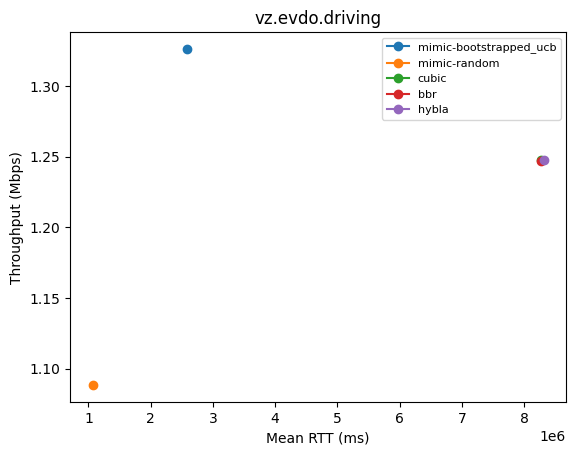

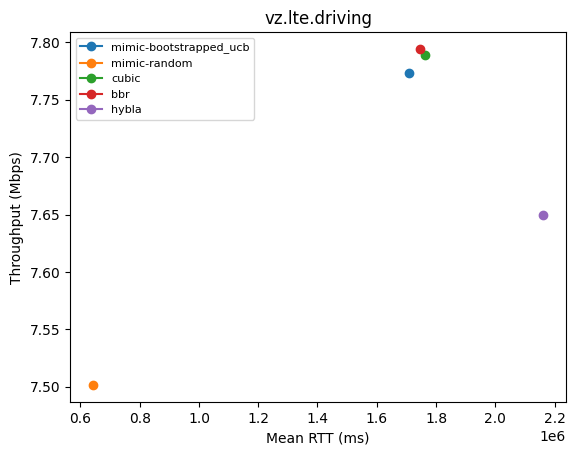

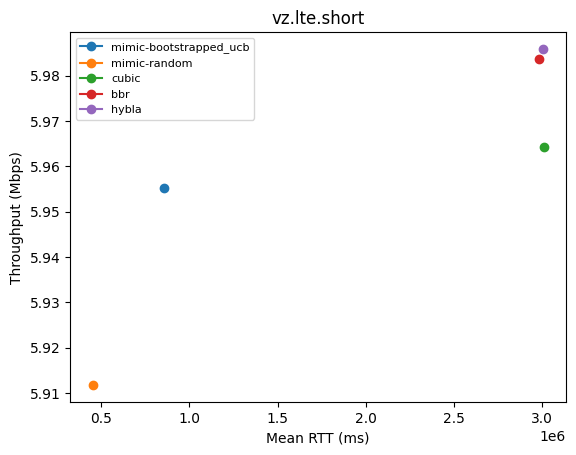

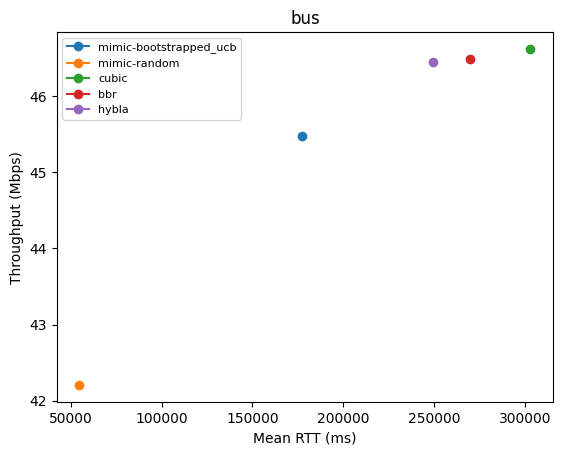

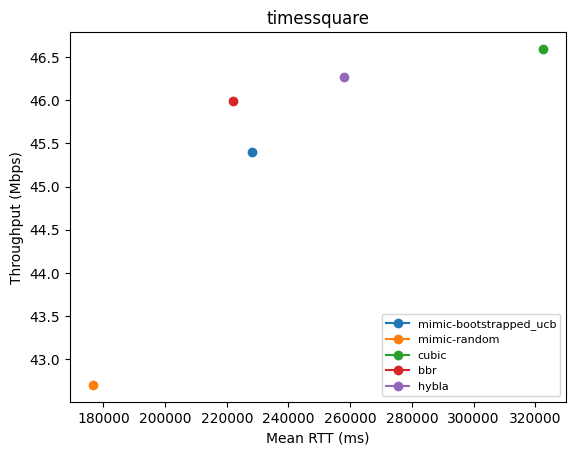

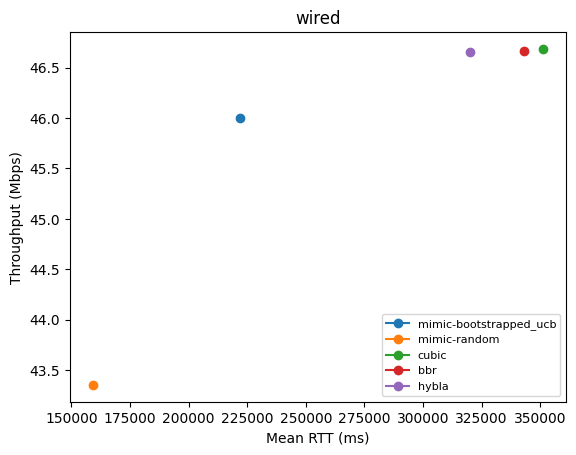

In [51]:
save = True
import matplotlib.pyplot as plt
for trace in traces:

    # Get mimic config
    mimic_config = read_json_file(get_config(f"{trace}.{policy}"))

    # Get native prot config
    cubic_config = read_json_file(get_config(f"cubic.{trace}"))
    bbr_config = read_json_file(get_config(f"bbr.{trace}"))
    hybla_config = read_json_file(get_config(f"hybla.{trace}"))
    random_config = read_json_file(get_config(f"{trace}.random_policy"))

    # Get metrics
    mimic_metrics = mimic_config['end']['streams'][0]['sender']
    cubic_metrics = cubic_config['end']['streams'][0]['sender']
    bbr_metrics = bbr_config['end']['streams'][0]['sender']
    hybla_metrics = hybla_config['end']['streams'][0]['sender']
    random_metrics = random_config['end']['streams'][0]['sender']


    #  Get latency
    mimic_min_rtt = mimic_metrics['mean_rtt']
    cubic_min_rtt = cubic_metrics['mean_rtt']
    bbr_min_rtt = bbr_metrics['mean_rtt']
    hybla_min_rtt = hybla_metrics['mean_rtt']
    random_min_rtt = random_metrics['mean_rtt']


    #  Get thruput
    mimic_thruput = mimic_metrics['bits_per_second']*10**(-6)
    cubic_thruput = cubic_metrics['bits_per_second']*10**(-6)
    bbr_thruput = bbr_metrics['bits_per_second']*10**(-6)
    hybla_thruput = hybla_metrics['bits_per_second']*10**(-6)
    random_thruput = random_metrics['bits_per_second']*10**(-6)

    # Plot
    fig, ax = plt.subplots()
    ax.plot(mimic_min_rtt, mimic_thruput, marker='o', label=f'mimic-{policy}')
    ax.plot(random_min_rtt, random_thruput, marker='o', label='mimic-random')
    ax.plot(cubic_min_rtt, cubic_thruput, marker='o', label='cubic')
    ax.plot(bbr_min_rtt, bbr_thruput, marker='o', label='bbr')
    ax.plot(hybla_min_rtt, hybla_thruput, marker='o', label='hybla')

    # set axis labels and legend
    ax.set_title(trace)
    ax.set_xlabel('Mean RTT (ms)', fontsize=10)
    ax.set_ylabel('Throughput (Mbps)', fontsize=10)
    ax.legend(fontsize=8)

    if save:
        filename = f"mab.{policy}.{trace}.thruput_vs_rtt.png"
        plt.savefig(os.path.join(path_to_plot_dir, filename))

    # show plot
    plt.show()
